# Sentiment Analysis – IMDB Movie Reviews (Portfolio Project)




## 1. Introduction

**Goal**: Build a binary classification model to predict whether a movie review is positive or negative based on the review text.

**Dataset**: IMDB Dataset of 50K Movie Reviews (25k positive, 25k negative).


In [1]:
import os
import pandas as pd

# List data files
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Load the CSV (adjust path if needed after you see the exact filename)
df = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')




/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


In [2]:
df.head()


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
df.shape

(50000, 2)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


## 2. Data understanding & cleaning

In [5]:
df.isna().sum()

review       0
sentiment    0
dtype: int64

In [6]:
df['sentiment'].value_counts()


sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [7]:

df['sentiment'].value_counts(normalize=True)


sentiment
positive    0.5
negative    0.5
Name: proportion, dtype: float64

In [9]:
df['review_length'] = df['review'].apply(lambda x: len(x.split()))



In [10]:
df['review_length'].describe()

count    50000.000000
mean       231.156940
std        171.343997
min          4.000000
25%        126.000000
50%        173.000000
75%        280.000000
max       2470.000000
Name: review_length, dtype: float64

no missing values, perfectly balanced classes (50% positive, 50% negative), and review lengths range from 4 to 2,470 words with an average of about 231 words.​

#### Text preprocessing :

In [11]:
import re

def clean_html(text):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

df['review_clean'] = df['review'].apply(clean_html)
df[['review', 'review_clean']].head(2)


,review,review_clean
0,One of the other reviewers has mentioned that ...,One of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,A wonderful little production. The filming tec...


#### Lowercase and remove punctuation:

In [12]:
import string

def preprocess_text(text):
    # lowercase
    text = text.lower()
    # remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

df['review_clean'] = df['review_clean'].apply(preprocess_text)
df['review_clean'].head(3)


0    one of the other reviewers has mentioned that ...
1    a wonderful little production the filming tech...
2    i thought this was a wonderful way to spend ti...
Name: review_clean, dtype: object

#### Encode sentiment as 0/1 for modeling:

In [13]:
df['sentiment_label'] = df['sentiment'].map({'negative': 0, 'positive': 1})
df[['sentiment', 'sentiment_label']].head()


,sentiment,sentiment_label
0,positive,1
1,positive,1
2,positive,1
3,negative,0
4,positive,1


## 3.Text EDA: Most common words in positive vs negative reviews

#### 1 . Split reviews by sentiment and get most common words:

In [16]:
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Remove stop words
positive_words_clean = [word for word in positive_words if word not in ENGLISH_STOP_WORDS and len(word) > 2]
negative_words_clean = [word for word in negative_words if word not in ENGLISH_STOP_WORDS and len(word) > 2]

# Top 20 most common words (without stop words)
positive_common = Counter(positive_words_clean).most_common(20)
negative_common = Counter(negative_words_clean).most_common(20)

print("Top 20 words in POSITIVE reviews (no stop words):")
print(positive_common)
print("\nTop 20 words in NEGATIVE reviews (no stop words):")
print(negative_common)



Top 20 words in POSITIVE reviews (no stop words):
[('film', 39418), ('movie', 36019), ('like', 17055), ('good', 14342), ('just', 13898), ('great', 12643), ('story', 12373), ('time', 11772), ('really', 10674), ('films', 8453), ('love', 8397), ('people', 8365), ('best', 8297), ('way', 7555), ('life', 7374), ('characters', 7177), ('think', 7129), ('movies', 7078), ('seen', 6608), ('dont', 6575)]

Top 20 words in NEGATIVE reviews (no stop words):
[('movie', 47487), ('film', 35044), ('like', 21770), ('just', 20774), ('good', 14141), ('bad', 14068), ('really', 12220), ('time', 11493), ('dont', 10005), ('story', 9673), ('people', 9115), ('make', 8985), ('movies', 8352), ('plot', 7791), ('acting', 7781), ('characters', 7477), ('way', 7439), ('think', 7060), ('watch', 6969), ('did', 6867)]


#### 2 .Visualize top words with bar charts:

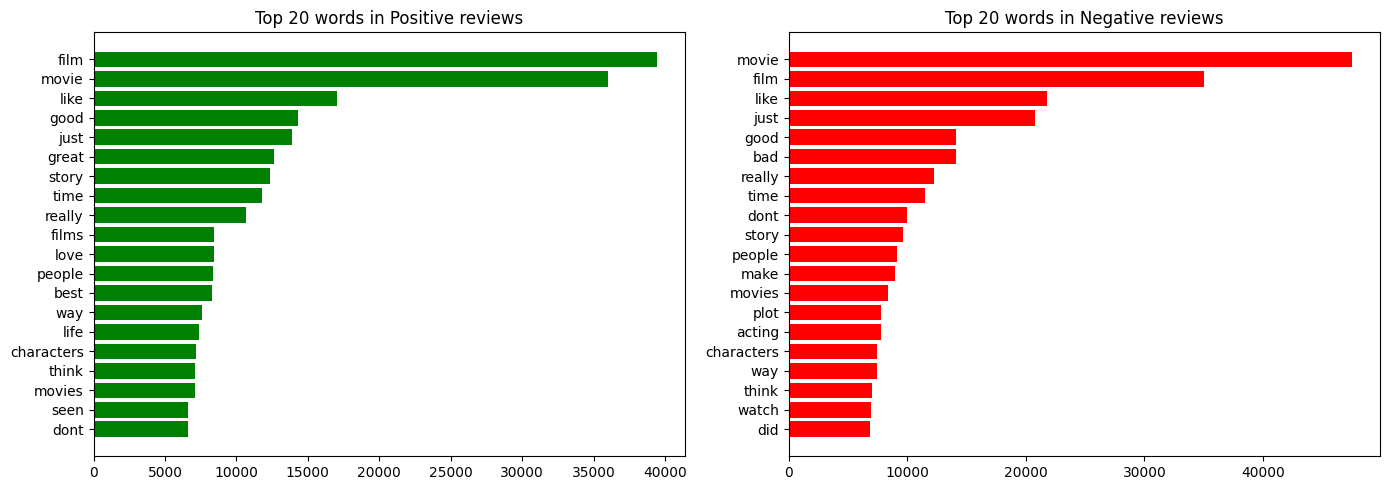

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert to dataframe for plotting
pos_df = pd.DataFrame(positive_common, columns=['word', 'count'])
neg_df = pd.DataFrame(negative_common, columns=['word', 'count'])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Positive words
axes[0].barh(pos_df['word'], pos_df['count'], color='green')
axes[0].set_title('Top 20 words in Positive reviews')
axes[0].invert_yaxis()

# Negative words
axes[1].barh(neg_df['word'], neg_df['count'], color='red')
axes[1].set_title('Top 20 words in Negative reviews')
axes[1].invert_yaxis()

plt.tight_layout()


**EDA Insights:**
- Positive reviews frequently use words like "great", "love", "best", "good", showing appreciation for the film, story, and characters.
- Negative reviews often contain words like "bad", "dont" (don't), and critical mentions of "plot" and "acting", indicating disappointment with specific aspects of the movie.


## 4. Modeling

In [18]:
from sklearn.model_selection import train_test_split

X = df['review_clean']
y = df['sentiment_label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape


((40000,), (10000,))

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

tfidf_lr = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, stop_words='english')),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])

tfidf_lr.fit(X_train, y_train)


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=5000, stop_words='english')),
                ('clf', LogisticRegression(max_iter=1000, random_state=42))])

In [20]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

y_pred = tfidf_lr.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8879

Confusion Matrix:
 [[4388  612]
 [ 509 4491]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.88      0.89      5000
           1       0.88      0.90      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



### Next: Extract most important words

In [21]:
# Get feature names and coefficients
feature_names = tfidf_lr.named_steps['tfidf'].get_feature_names_out()
coefficients = tfidf_lr.named_steps['clf'].coef_[0]

# Top 15 words for positive sentiment (highest coefficients)
top_positive_idx = coefficients.argsort()[-15:][::-1]
top_positive_words = [(feature_names[i], coefficients[i]) for i in top_positive_idx]

# Top 15 words for negative sentiment (lowest coefficients)
top_negative_idx = coefficients.argsort()[:15]
top_negative_words = [(feature_names[i], coefficients[i]) for i in top_negative_idx]

print("Top 15 words indicating POSITIVE sentiment:")
for word, coef in top_positive_words:
    print(f"{word}: {coef:.3f}")

print("\nTop 15 words indicating NEGATIVE sentiment:")
for word, coef in top_negative_words:
    print(f"{word}: {coef:.3f}")


Top 15 words indicating POSITIVE sentiment:
great: 6.921
excellent: 6.807
perfect: 5.155
best: 5.123
amazing: 4.947
710: 4.946
wonderful: 4.703
loved: 4.689
hilarious: 4.446
favorite: 4.389
enjoyed: 4.302
fun: 3.945
brilliant: 3.908
superb: 3.884
810: 3.819

Top 15 words indicating NEGATIVE sentiment:
worst: -10.049
waste: -8.285
awful: -7.696
bad: -7.123
boring: -6.112
poor: -5.613
terrible: -5.441
poorly: -5.278
worse: -5.239
dull: -5.116
horrible: -4.952
fails: -4.771
disappointment: -4.654
disappointing: -4.490
annoying: -4.319


## Conclusions

This sentiment analysis project successfully classified IMDB movie reviews as positive or negative with **88.79% accuracy** using TF-IDF vectorization and Logistic Regression.

**Key findings:**
- The model achieved balanced performance: 89% F1-score for both positive and negative classes
- Feature importance analysis shows the model learned interpretable sentiment words: "great", "excellent", "best" for positive reviews and "worst", "waste", "terrible" for negative reviews
- Simple preprocessing (lowercase, punctuation removal, stop word filtering) combined with TF-IDF was sufficient for strong performance

**Business applications:**
- Automatically classify customer reviews for products, movies, restaurants, or services
- Monitor brand sentiment on social media at scale
- Identify negative feedback quickly for customer service prioritization

**Next steps:**
- Try advanced models like BERT or RoBERTa for potentially higher accuracy
- Build a simple web app to classify user-submitted reviews in real-time
- Extend to multi-class sentiment (positive, neutral, negative) or aspect-based sentiment analysis
